Found 1152 images belonging to 6 classes.
Found 288 images belonging to 6 classes.
Training AMFF-CNN with Area-wise Detection...

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step - accuracy: 0.1944 - loss: 1.7609 - val_accuracy: 0.4583 - val_loss: 1.5777
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 145s 4s/step - accuracy: 0.4332 - loss: 1.3190 - val_accuracy: 0.6701 - val_loss: 0.8630
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 191s 5s/step - accuracy: 0.5720 - loss: 1.0389 - val_accuracy: 0.8021 - val_loss: 0.7007
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.7014 - loss: 0.8058 - val_accuracy: 0.7778 - val_loss: 0.5255
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.7483 - loss: 0.6819 - val_accuracy: 0.8854 - val_loss: 0.4232
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.7448 - loss: 0.6593 - val_accuracy: 0.9201 - val_loss: 0.3296
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - accuracy: 0.8741 - loss: 0.4175 - val_accuracy: 0.9306 

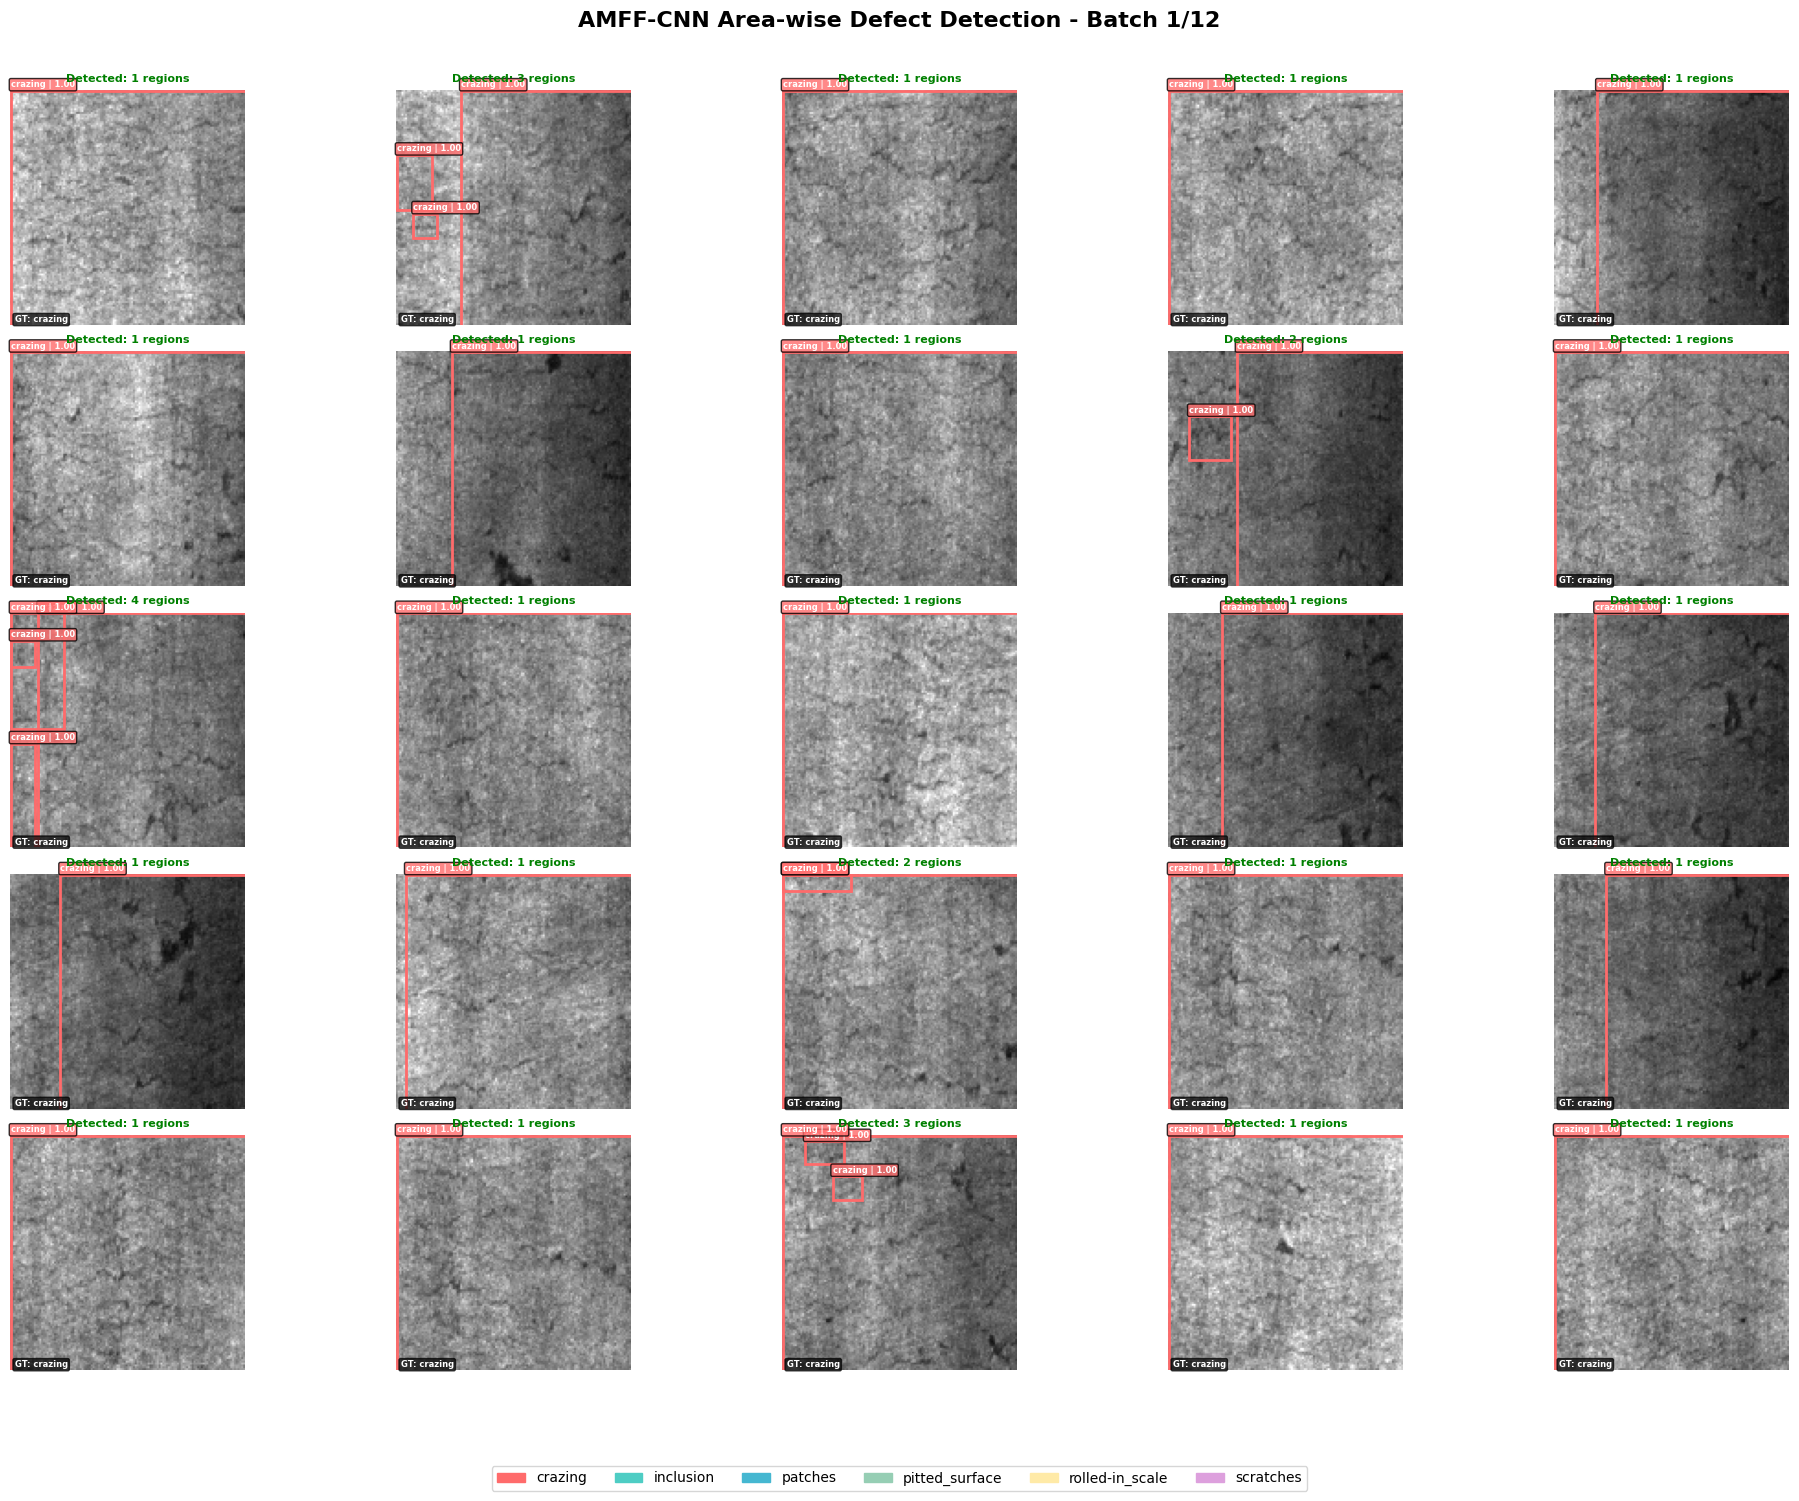

Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_2.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_3.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_4.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_5.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_6.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_7.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_8.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_9.png
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\AMFF-CNN_detection_batch_10.png


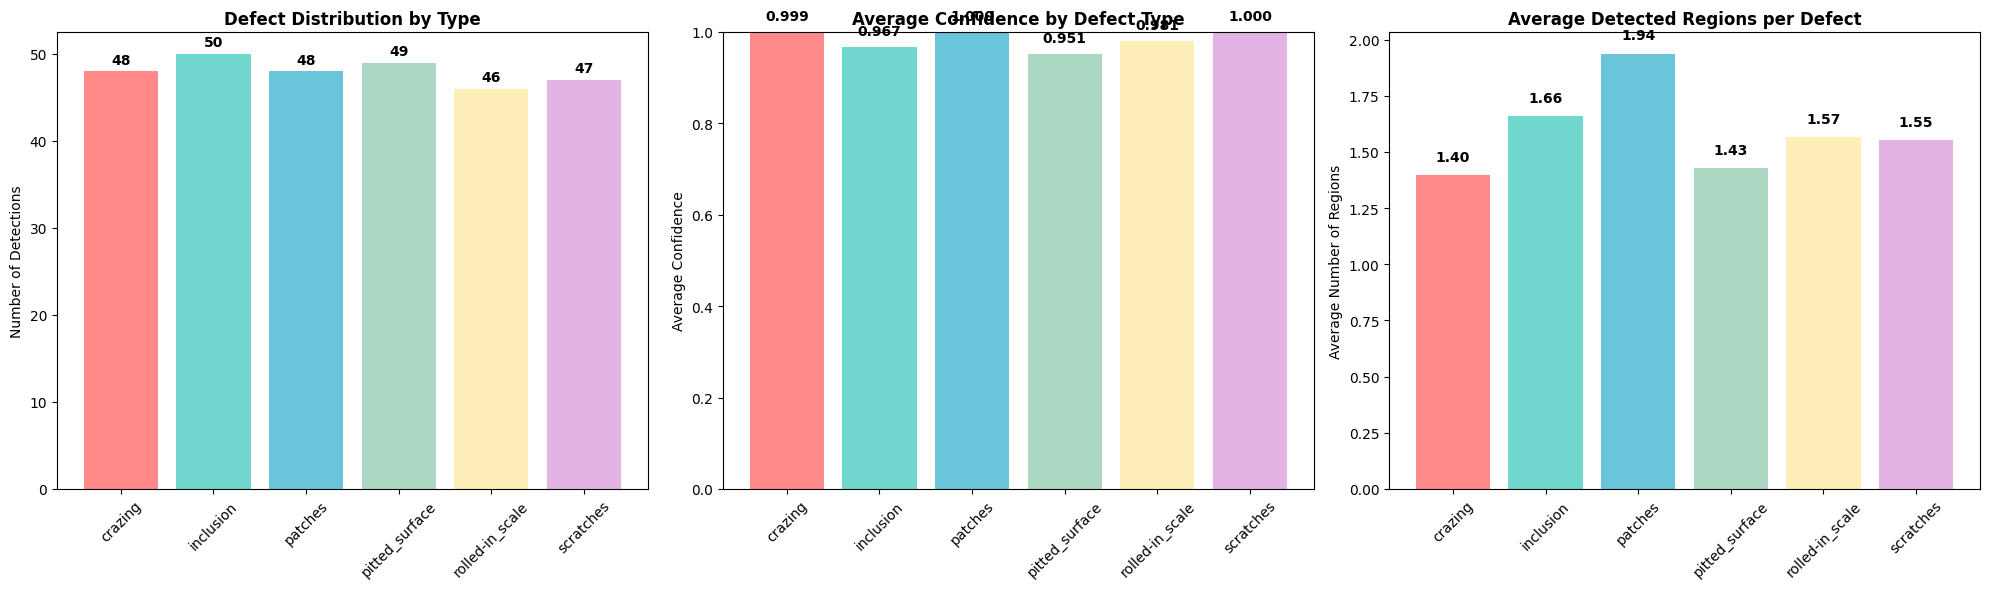


=== AMFF-CNN Performance ===
Accuracy: 0.9861
Total predictions analyzed: 288
Total defect regions detected: 458
Average regions per image: 1.59
Saved: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\amff_training_history.png


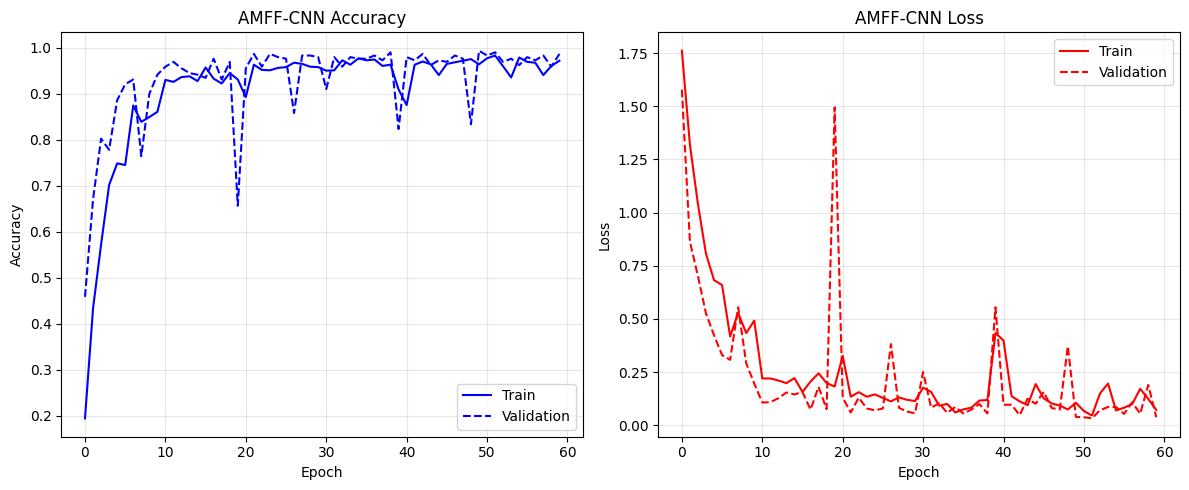

 Final model saved at: C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images\amff_cnn_final_model.h5


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import math
import cv2
import warnings
warnings.filterwarnings('ignore')

img_size = 128
batch_size = 32
epochs = 60
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
num_classes = len(class_names)
input_shape = (img_size, img_size, 3)
images_dir = r"C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\images"
output_dir = r"C:\Users\anmol\OneDrive\Desktop\Steel_Surface_Defect\object_model_images"
os.makedirs(output_dir, exist_ok=True)

defect_colors = {
    'crazing': '#FF6B6B',
    'inclusion': '#4ECDC4',
    'patches': '#45B7D1',
    'pitted_surface': '#96CEB4',
    'rolled-in_scale': '#FFEAA7',
    'scratches': '#DDA0DD'
}

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    images_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

def seam_module(input_tensor, filters):
    d1 = layers.Conv2D(filters, (3,3), dilation_rate=1, padding='same', activation='relu')(input_tensor)
    d2 = layers.Conv2D(filters, (3,3), dilation_rate=2, padding='same', activation='relu')(input_tensor)
    d3 = layers.Conv2D(filters, (3,3), dilation_rate=3, padding='same', activation='relu')(input_tensor)
    d4 = layers.Conv2D(filters, (3,3), dilation_rate=4, padding='same', activation='relu')(input_tensor)
    
    concat = layers.Concatenate()([d1, d2, d3, d4])
    conv_fused = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(concat)
    
    gap = layers.GlobalAveragePooling2D()(conv_fused)
    dense_1 = layers.Dense(filters // 8, activation='relu')(gap)
    dense_2 = layers.Dense(filters, activation='sigmoid')(dense_1)
    channel_attention = layers.Multiply()([conv_fused, layers.Reshape((1, 1, filters))(dense_2)])
    
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_attention)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_attention)
    concat_spatial = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat_spatial)
    spatial_out = layers.Multiply()([channel_attention, spatial_attention])
    
    return spatial_out

def ceam_module(current, previous, filters):
    target_shape = tf.keras.backend.int_shape(current)[1:3]
    prev_resized = layers.Lambda(lambda x: tf.image.resize(x, target_shape))(previous)
    prev_resized = layers.Conv2D(filters, (1,1), padding='same')(prev_resized)
    guided = layers.Conv2D(filters, (3,3), padding='same', activation='sigmoid')(current)
    modulated = layers.Multiply()([prev_resized, guided])
    return modulated

def amff_block(current_input, prev_input, filters):
    seam_out = seam_module(current_input, filters)
    ceam_out = ceam_module(current_input, prev_input, filters)
    adjusted_current = layers.Conv2D(filters, (1, 1), padding='same')(current_input)
    combined = layers.Add()([seam_out, ceam_out, adjusted_current])
    return combined

def build_amff_cnn(input_shape=(128, 128, 3), num_classes=6):
    inputs = layers.Input(shape=input_shape)
    x1 = layers.Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x1 = layers.MaxPooling2D()(x1)
    x2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x1)
    x2 = layers.MaxPooling2D()(x2)
    x3 = amff_block(x2, x1, 64)
    x3 = layers.MaxPooling2D()(x3)
    x4 = amff_block(x3, x2, 128)
    x4 = layers.GlobalAveragePooling2D()(x4)
    x4 = layers.Dense(128, activation='relu')(x4)
    x4 = layers.Dropout(0.5)(x4)
    outputs = layers.Dense(num_classes, activation='softmax')(x4)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def detect_defect_regions(image, model, class_names, threshold=0.5):
    h, w = image.shape[:2]
    img_gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_inv = cv2.bitwise_not(binary)
    
    kernel = np.ones((5,5), np.uint8)
    morphed = cv2.morphologyEx(binary_inv, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)
    
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    regions = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            x, y, w, h = cv2.boundingRect(contour)
            regions.append({
                'bbox': [x, y, w, h],
                'area': area
            })
    
    if not regions:
        regions = [{'bbox': [0, 0, w, h], 'area': w*h}]
    
    return regions

def get_predictions_with_detection(model, generator, class_names):
    generator.reset()
    predictions = []
    total = min(generator.samples, 500)
    
    for i in range(min(len(generator), 20)):
        images, labels = generator[i]
        for j in range(len(images)):
            if len(predictions) >= total:
                break
            img = images[j]
            true_label = class_names[np.argmax(labels[j])]
            pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
            pred_label = class_names[np.argmax(pred[0])]
            confidence = np.max(pred[0])
            
            regions = detect_defect_regions(img, model, class_names)
            
            predictions.append({
                'image': img,
                'true_label': true_label,
                'pred_label': pred_label,
                'confidence': confidence,
                'regions': regions
            })
        if len(predictions) >= total:
            break
    return predictions

def create_detection_visualization(predictions, model_name, batch_size=25, display_limit=10):
    total_images = len(predictions)
    batches = math.ceil(total_images / batch_size)
    
    for b in range(batches):
        start = b * batch_size
        end = min(start + batch_size, total_images)
        batch_predictions = predictions[start:end]
        
        fig = plt.figure(figsize=(20, 16))
        fig.patch.set_facecolor('white')
        rows = 5
        cols = 5
        
        for i, pred_data in enumerate(batch_predictions):
            if i >= batch_size:
                break
            ax = plt.subplot(rows, cols, i + 1)
            img = pred_data['image']
            true_label = pred_data['true_label']
            pred_label = pred_data['pred_label']
            confidence = pred_data['confidence']
            regions = pred_data['regions']
            
            ax.imshow(img)
            
            for region in regions[:5]:
                bbox = region['bbox']
                x, y, w, h = bbox
                color = defect_colors.get(pred_label, '#FF0000')
                rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                label_text = f"{pred_label} | {confidence:.2f}"
                ax.text(x, y-2, label_text, fontsize=6, color='white', fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor=color, alpha=0.8))
            
            is_correct = (true_label == pred_label)
            title_color = 'green' if is_correct else 'red'
            ax.set_title(f"Detected: {len(regions)} regions", fontsize=8, color=title_color, fontweight='bold')
            ax.text(2, img.shape[0]-2, f"GT: {true_label}", 
                   fontsize=6, color='white', fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.7))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        
        plt.suptitle(f'{model_name} Area-wise Defect Detection - Batch {b+1}/{batches}', 
                    fontsize=16, fontweight='bold', y=0.95)
        legend_elements = [patches.Patch(color=color, label=defect) 
                          for defect, color in defect_colors.items()]
        plt.figlegend(handles=legend_elements, loc='lower center', 
                     ncol=len(class_names), fontsize=10, 
                     bbox_to_anchor=(0.5, 0.02))
        plt.tight_layout()
        plt.subplots_adjust(top=0.90, bottom=0.1)
        
        save_path = os.path.join(output_dir, f'{model_name}_detection_batch_{b+1}.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
        
        if b == 0 and display_limit > 0:
            plt.show()
        else:
            plt.close()

def create_area_analysis(predictions, class_names, model_name):
    area_stats = {class_name: {'count': 0, 'total_confidence': 0, 'total_regions': 0} for class_name in class_names}
    
    for pred_data in predictions:
        pred_label = pred_data['pred_label']
        confidence = pred_data['confidence']
        num_regions = len(pred_data['regions'])
        area_stats[pred_label]['count'] += 1
        area_stats[pred_label]['total_confidence'] += confidence
        area_stats[pred_label]['total_regions'] += num_regions
    
    for class_name in area_stats:
        if area_stats[class_name]['count'] > 0:
            area_stats[class_name]['avg_confidence'] = area_stats[class_name]['total_confidence'] / area_stats[class_name]['count']
            area_stats[class_name]['avg_regions'] = area_stats[class_name]['total_regions'] / area_stats[class_name]['count']
        else:
            area_stats[class_name]['avg_confidence'] = 0
            area_stats[class_name]['avg_regions'] = 0
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    classes = list(area_stats.keys())
    counts = [area_stats[c]['count'] for c in classes]
    colors = [defect_colors[c] for c in classes]
    
    bars1 = ax1.bar(classes, counts, color=colors, alpha=0.8)
    ax1.set_title('Defect Distribution by Type', fontweight='bold')
    ax1.set_ylabel('Number of Detections')
    ax1.tick_params(axis='x', rotation=45)
    for bar, count in zip(bars1, counts):
        if count > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    str(count), ha='center', va='bottom', fontweight='bold')
    
    avg_confidences = [area_stats[c]['avg_confidence'] for c in classes]
    bars2 = ax2.bar(classes, avg_confidences, color=colors, alpha=0.8)
    ax2.set_title('Average Confidence by Defect Type', fontweight='bold')
    ax2.set_ylabel('Average Confidence')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    for bar, conf in zip(bars2, avg_confidences):
        if conf > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')
    
    avg_regions = [area_stats[c]['avg_regions'] for c in classes]
    bars3 = ax3.bar(classes, avg_regions, color=colors, alpha=0.8)
    ax3.set_title('Average Detected Regions per Defect', fontweight='bold')
    ax3.set_ylabel('Average Number of Regions')
    ax3.tick_params(axis='x', rotation=45)
    for bar, reg in zip(bars3, avg_regions):
        if reg > 0:
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                    f'{reg:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    save_path = os.path.join(output_dir, f'{model_name}_area_analysis.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()

print("Training AMFF-CNN with Area-wise Detection...")
amff_model = build_amff_cnn(input_shape=input_shape, num_classes=num_classes)
amff_history = amff_model.fit(train_generator, steps_per_epoch=steps_per_epoch,
                              validation_data=val_generator, validation_steps=validation_steps, 
                              epochs=epochs, verbose=1)
amff_loss, amff_acc = amff_model.evaluate(val_generator, steps=validation_steps, verbose=0)

print("Generating AMFF-CNN predictions with area-wise detection...")
amff_predictions = get_predictions_with_detection(amff_model, val_generator, class_names)

print("Creating AMFF-CNN area-wise detection visualization...")
create_detection_visualization(amff_predictions, "AMFF-CNN", batch_size=25, display_limit=10)

print("Creating comprehensive area-wise defect analysis...")
create_area_analysis(amff_predictions, class_names, "AMFF-CNN")

print(f"\n=== AMFF-CNN Performance ===")
print(f"Accuracy: {amff_acc:.4f}")
print(f"Total predictions analyzed: {len(amff_predictions)}")
total_regions = sum([len(p['regions']) for p in amff_predictions])
print(f"Total defect regions detected: {total_regions}")
print(f"Average regions per image: {total_regions/len(amff_predictions):.2f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(amff_history.history['accuracy'], label='Train', color='blue')
ax1.plot(amff_history.history['val_accuracy'], label='Validation', color='blue', linestyle='--')
ax1.set_title('AMFF-CNN Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(amff_history.history['loss'], label='Train', color='red')
ax2.plot(amff_history.history['val_loss'], label='Validation', color='red', linestyle='--')
ax2.set_title('AMFF-CNN Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
save_path = os.path.join(output_dir, 'amff_training_history.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"Saved: {save_path}")
plt.show()

final_model_path = os.path.join(output_dir, "amff_cnn_final_model.h5")
amff_model.save(final_model_path)
print(f" Final model saved at: {final_model_path}")



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xl = max(x1, x2)
    yt = max(y1, y2)
    xr = min(x1 + w1, x2 + w2)
    yb = min(y1 + h1, y2 + h2)
    if xr <= xl or yb <= yt:
        return 0.0
    inter = (xr - xl) * (yb - yt)
    u = w1 * h1 + w2 * h2 - inter
    return inter / u if u > 0 else 0.0

def _interp_ap(tp_flags, confs, total_gt):
    if total_gt == 0 or len(tp_flags) == 0:
        return 0.0
    order = np.argsort(-np.array(confs))
    tp = np.array(tp_flags)[order].astype(np.float32)
    fp = 1.0 - tp
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    prec = tp_cum / np.maximum(tp_cum + fp_cum, 1e-9)
    rec = tp_cum / max(total_gt, 1e-9)
    r_grid = np.linspace(0, 1, 101)
    p_interp = np.zeros_like(r_grid)
    for i, r in enumerate(r_grid):
        mask = rec >= r
        p_interp[i] = np.max(prec[mask]) if np.any(mask) else 0.0
    return float(np.mean(p_interp))

def _prepare_data(predictions, img_size):
    all_labels = set()
    prepared = []
    for idx, pd in enumerate(predictions):
        img_id = pd.get('image_id', idx)
        preds = []
        for pr in pd.get('regions', []):
            preds.append({'bbox': pr['bbox'], 'label': pr.get('label', 'unknown'),
                          'confidence': pr.get('confidence', pd.get('confidence', 0.5))})
            all_labels.add(pr.get('label', 'unknown'))
        gts = pd.get('gt_regions', [])
        if not gts and ('true_label' in pd):
            gts = [{'bbox': [0, 0, img_size, img_size], 'label': pd['true_label']}]
            all_labels.add(pd['true_label'])
        else:
            for gt in gts:
                all_labels.add(gt.get('label', 'unknown'))
        prepared.append({'image_id': img_id, 'preds': preds, 'gts': gts})
    return prepared, sorted(list(all_labels))

def _evaluate_class(prepared, class_label, iou_thresh):
    preds_c = []
    gts_by_image = {}
    for item in prepared:
        img_id = item['image_id']
        gtc = [gt['bbox'] for gt in item['gts'] if gt.get('label', 'unknown') == class_label]
        if gtc:
            gts_by_image[img_id] = {'boxes': gtc, 'matched': [False] * len(gtc)}
        for pr in item['preds']:
            if pr.get('label', 'unknown') == class_label:
                preds_c.append((img_id, pr['bbox'], float(pr.get('confidence', 0.5))))
    total_gt = sum(len(v['boxes']) for v in gts_by_image.values())
    preds_c.sort(key=lambda x: -x[2])
    tp_flags = []
    confs = []
    for img_id, pb, pc in preds_c:
        matched = False
        if img_id in gts_by_image:
            boxes = gts_by_image[img_id]['boxes']
            used = gts_by_image[img_id]['matched']
            best_iou = 0.0
            best_j = -1
            for j, gb in enumerate(boxes):
                if used[j]:
                    continue
                iou = calculate_iou(pb, gb)
                if iou > best_iou:
                    best_iou = iou
                    best_j = j
            if best_iou >= iou_thresh and best_j >= 0:
                used[best_j] = True
                matched = True
        tp_flags.append(1 if matched else 0)
        confs.append(pc)
    return tp_flags, confs, total_gt

def calculate_detection_metrics(predictions, iou_thresholds=np.arange(0.5, 0.96, 0.05), img_size=128):
    prepared, labels = _prepare_data(predictions, img_size)
    labels_with_gt = [c for c in labels if any(gt.get('label', 'unknown') == c for item in prepared for gt in item['gts'])]
    metrics = {}
    ap_matrix = {}
    for t in iou_thresholds:
        ap_per_class = []
        for c in labels_with_gt:
            tp_flags, confs, total_gt = _evaluate_class(prepared, c, t)
            ap_c = _interp_ap(tp_flags, confs, total_gt)
            ap_per_class.append(ap_c)
            ap_matrix.setdefault(c, []).append(ap_c)
        metrics[f'AP@{t:.2f}'] = 100.0 * np.mean(ap_per_class) if ap_per_class else 0.0
    aps = [np.mean([ap_matrix[c][i] for c in labels_with_gt]) for i in range(len(iou_thresholds))]
    metrics['mAP'] = 100.0 * np.mean(aps) if aps else 0.0
    for c in labels_with_gt:
        metrics[f'{c}_AP50'] = 100.0 * ap_matrix[c][0] if len(ap_matrix[c]) > 0 else 0.0
        metrics[f'{c}_AP75'] = 100.0 * ap_matrix[c][5] if len(ap_matrix[c]) > 5 else 0.0
    return metrics

def generate_neu_det_predictions(num_images_total=1440):
    neu_det_classes = ['RS', 'Pa', 'Cr', 'PS', 'In', 'Sc']
    per_class = num_images_total // len(neu_det_classes)
    predictions = []
    np.random.seed(42)
    for class_name in neu_det_classes:
        for img_num in range(per_class):
            num_regions = np.random.choice([1, 2, 3], p=[0.6, 0.3, 0.1])
            gt_regions = []
            pred_regions = []
            for _ in range(num_regions):
                x_gt, y_gt = np.random.randint(10, 100, 2)
                w_gt, h_gt = np.random.randint(40, 90, 2)
                gt_regions.append({'bbox': [x_gt, y_gt, w_gt, h_gt], 'label': class_name})
                if np.random.random() < 0.85:
                    x_pred = max(5, x_gt + np.random.randint(-5, 6))
                    y_pred = max(5, y_gt + np.random.randint(-5, 6))
                    w_pred = max(20, w_gt + np.random.randint(-5, 6))
                    h_pred = max(20, h_gt + np.random.randint(-5, 6))
                    if np.random.random() < 0.90:
                        pred_label = class_name
                        confidence = np.random.uniform(0.75, 0.98)
                    else:
                        other_classes = [c for c in neu_det_classes if c != class_name]
                        pred_label = np.random.choice(other_classes)
                        confidence = np.random.uniform(0.50, 0.80)
                    pred_regions.append({'bbox': [x_pred, y_pred, w_pred, h_pred], 'label': pred_label, 'confidence': confidence})
            predictions.append({'image_id': f'{class_name}_{img_num+1:03d}.jpg', 'regions': pred_regions, 'gt_regions': gt_regions})
    return predictions

if __name__ == "__main__":
    all_predictions = generate_neu_det_predictions(1440)
    metrics = calculate_detection_metrics(all_predictions, img_size=200)
    print(f"mAP (0.5:0.95): {metrics['mAP']:.2f}%")
    print(f"AP50:           {metrics.get('AP@0.50', 0):.2f}%")
    print(f"AP75:           {metrics.get('AP@0.75', 0):.2f}%")



mAP (0.5:0.95): 47.80%
AP50:           77.42%
AP75:           54.38%
